In [246]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

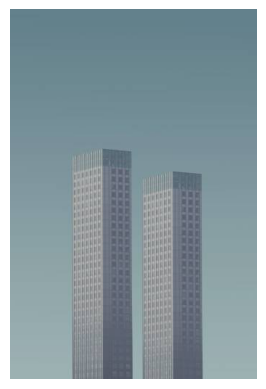

In [247]:
img = plt.imread("img/original.jpg")
plt.imshow(img)
plt.axis("off")
plt.show()

## RGB to HSI

In [248]:
# 添加一个非常小的数以避免除以零
epsilon = 1e-10
R = img[:,:,0]
G = img[:,:,1]
B = img[:,:,2]
# 计算灰度 I
I = (R + G + B) / 3.0
plt.imsave("img/original_I.jpg",I,cmap="gray")

#计算饱和度 S
min_rgb = np.minimum(np.minimum(R,G),B)
S = np.zeros_like(I)
non_zero_mask = I > epsilon
S[non_zero_mask] = 1.0 - min_rgb[non_zero_mask]/I[non_zero_mask]
S = np.clip(S, 0.0, 1.0)

# 计算色调 H
H = np.zeros_like(I)
numerator = 0.5*((R-G) + (R-B))
denominator = np.sqrt((R-G)**2 + (R-B)*(G-B) + epsilon)
theta_arg = numerator / denominator
# 关键: 将 arccos 的参数裁剪到 [-1, 1] 以确保数值稳定性
theta_arg = np.clip(theta_arg, -1.0, 1.0)
theta = np.arccos(theta_arg)

## B > G 的掩膜
mask_b_gt_g = B > G
H = theta
H[mask_b_gt_g] = 2*np.pi - theta[mask_b_gt_g]


grayscale_mask = S < epsilon
H[grayscale_mask] = 0.0

## 直方图均衡化

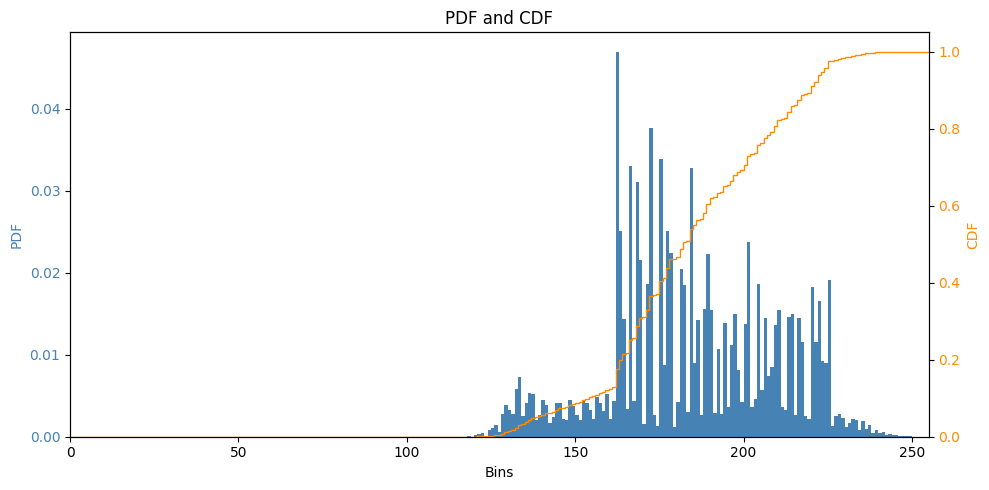

In [249]:
# 归一化到0-255
I= np.floor(I*255/np.max(I)).astype(np.uint8)
# 计算直方图
counts, bins = np.histogram(I, bins=256, range=(0, 256))
# 计算pdf
counts = np.array(counts)
pdf = counts / np.sum(counts)
# 计算cdf
cdf = np.cumsum(pdf)

# 创建一个图形对象
fig, ax1 = plt.subplots(figsize=(10, 5))
# 绘制PDF
ax1.stairs(pdf, bins, fill=True, label='PDF',color = "steelblue")
ax1.set_xlabel('Bins')
ax1.set_ylabel('PDF',color = "steelblue")
ax1.tick_params(axis='y',labelcolor = "steelblue")
ax1.set_xlim([0, 255])

# 创建第二个y轴，共享x轴
ax2 = ax1.twinx()
ax2.stairs(cdf, bins, label='CDF',color ='darkorange' )
ax2.set_ylabel('CDF',color='darkorange')
ax2.tick_params(axis='y',labelcolor='darkorange')

# 设置图形标题
plt.title('PDF and CDF')

# 显示图形
fig.tight_layout()
plt.show()


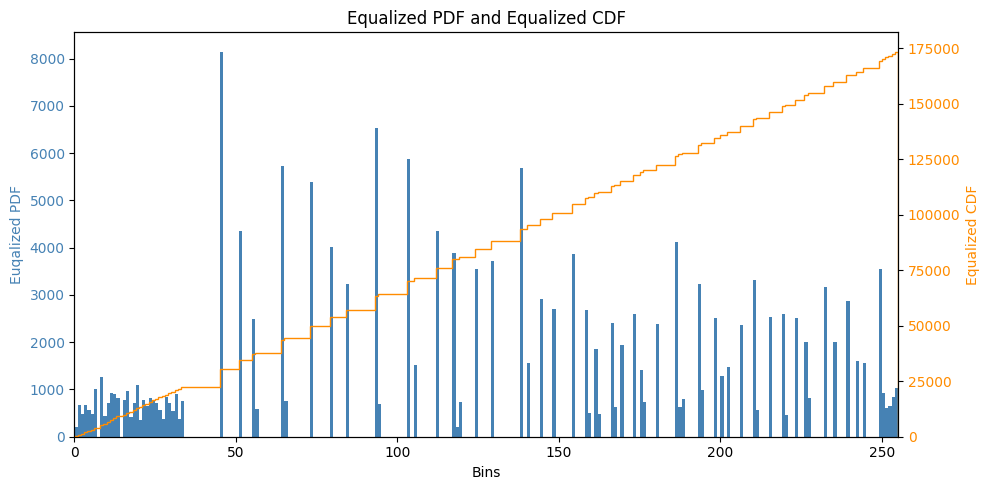

In [250]:
# 计算映射表
map_table = np.around(255*cdf).astype(np.uint8)
# 映射
equalized_I = map_table[I]
counts,bins = np.histogram(equalized_I,bins=np.linspace(0,255,256))
countsCDF = np.cumsum(counts)

fig, ax1 = plt.subplots(figsize=(10, 5))
# 绘制PDF
ax1.stairs(counts, bins, fill=True, label='PDF',color = "steelblue")
ax1.set_xlabel('Bins')
ax1.set_ylabel('Euqalized PDF',color = "steelblue")
ax1.tick_params(axis='y',labelcolor = "steelblue")
ax1.set_xlim([0, 255])

# 创建第二个y轴，共享x轴
ax2 = ax1.twinx()
ax2.stairs(countsCDF, bins, label='CDF',color ='darkorange')
ax2.set_ylabel('Equalized CDF',color='darkorange')
ax2.tick_params(axis='y',labelcolor='darkorange')

# 设置图形标题
plt.title('Equalized PDF and Equalized CDF')

# 显示图形
fig.tight_layout()
plt.show()
# plt.savefig("img/均衡后的直方图")

In [251]:
equalized_I = equalized_I / 255
plt.imsave("img/equalized_I.jpg",equalized_I,cmap="gray")

## RGB to HSI

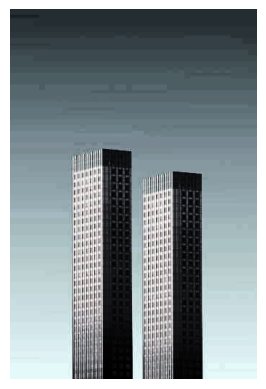

In [252]:
r = np.zeros_like(I,dtype=float)
g = np.zeros_like(I,dtype=float)
b = np.zeros_like(I,dtype=float)
# --- 情况 1: 色调在 [0, 2*pi/3) 区间 ---
mask1 = (H >= 0) & (H < 2*np.pi/3)
H_masked = H[mask1]
S_masked = S[mask1]
I_masked = equalized_I[mask1]

b[mask1] = I_masked*(1 - S_masked)
r[mask1] = I_masked*(1 + (S_masked*np.cos(H_masked)) / np.cos(np.pi / 3 - H_masked))
g[mask1] = 3 * I_masked - (r[mask1] + b[mask1])

# --- 情况 2: 色相在 [2*pi/3, 4*pi/3) 区间 ---
mask2 = (H >= 2*np.pi/3) & (H < 4*np.pi/3)
H_masked = H[mask2] - (2*np.pi/3)
S_masked = S[mask2]
I_masked = equalized_I[mask2]

r[mask2] = I_masked * (1 - S_masked)
g[mask2] = I_masked * (1 + (S_masked * np.cos(H_masked)) / np.cos(np.pi / 3 - H_masked))
b[mask2] = 3 * I_masked - (r[mask2] + g[mask2])

# --- 情况 3: 色相在 [4*pi/3, 2*pi) 区间 ---
mask3 = (H >= 4 * np.pi / 3) & (H < 2 * np.pi) #
H_masked = H[mask3] - (4 * np.pi / 3) # 调整 H 到 [0, 2*pi/3)
S_masked = S[mask3]
I_masked = equalized_I[mask3]

g[mask3] = I_masked * (1 - S_masked)
b[mask3] = I_masked * (1 + (S_masked * np.cos(H_masked)) / np.cos(np.pi / 3 - H_masked))
r[mask3] = 3 * I_masked - (g[mask3] + b[mask3])


# 合并为RGB图像
r = r*255/np.max(r)
g = g*255/np.max(g)
b = b*255/np.max(b)
equalized_img = np.clip(np.dstack((r, g, b))/255,0.0,1.0)
plt.imshow(equalized_img)
plt.axis("off")
plt.show()
plt.imsave("img/equalized_img.jpg",equalized_img)
